Install packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install body-matrix==0.3.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install av 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 52.1 MB/s eta 0:00:00


Load Video, Detection and Segmentation Models

In [4]:
from body_matrix import load, infer, process, score, draw, export

keypoints_model, keypoints_transform = load.keypoints_model("cuda")
segment_model, segment_transforms = load.segment_model("cuda")
video, frame_counts, fps, sample_frame = load.video(
    "/content/drive/MyDrive/Body_Matrix/Raw_Vids/vanphuc_lieugiai_girl.mp4", 
    -90, 
    1
)

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth


  0%|          | 0.00/226M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth


  0%|          | 0.00/177M [00:00<?, ?B/s]

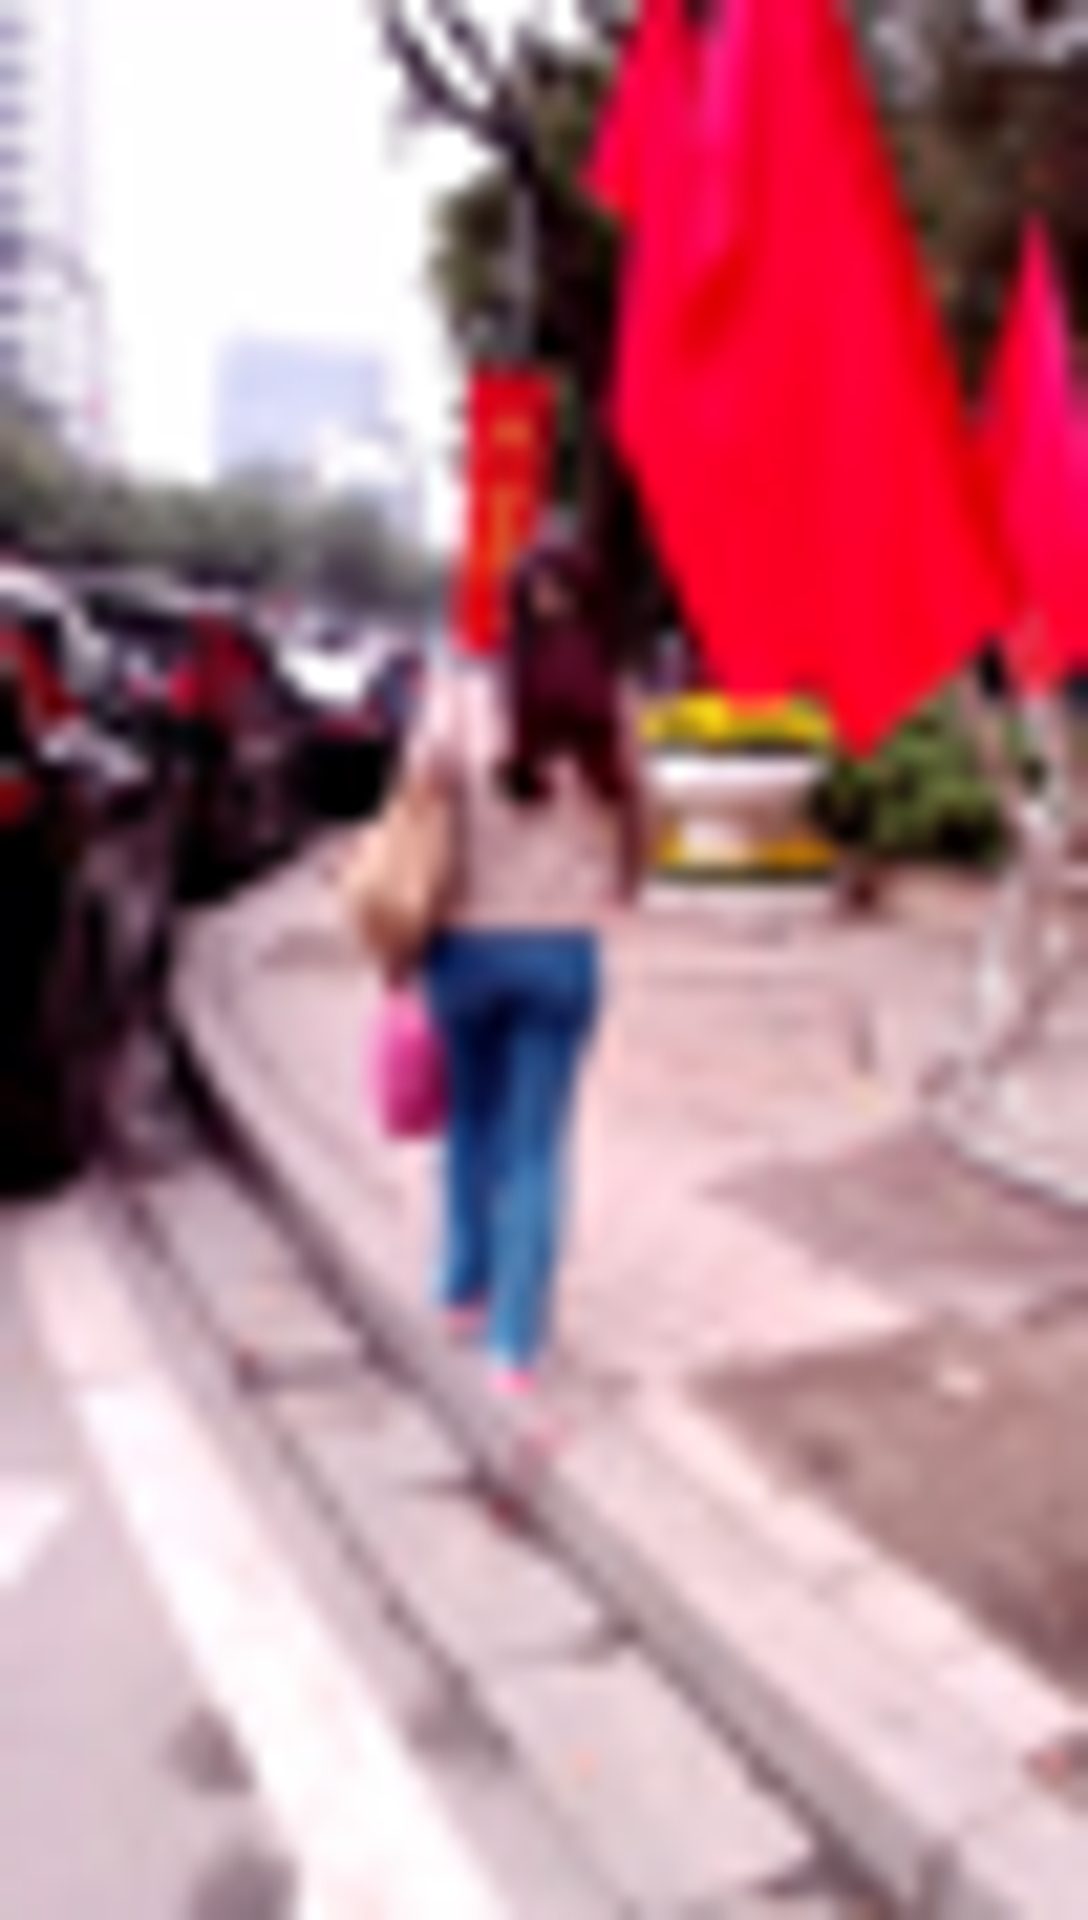

In [5]:
pixelated = draw.pixelate(sample_frame, 21)
pixelated

In [6]:
from PIL import Image
import numpy as np

def add_thong_score_to_frame(frame):
    selected_box, keypoints = infer.detect_main_target(
        frame, "cuda", 0.8, keypoints_model, keypoints_transform
    )

    mask, mask_image, bool_mask = infer.segment_selected_target(
        frame, "cuda", selected_box, 0.99, segment_model, segment_transforms
    )

    selected_kps = process.keypoints_filter(
        [
            'left_ear', 'right_ear',
            'left_shoulder','right_shoulder',
            'left_wrist','right_wrist',
            'left_hip', 'right_hip',
            'left_ankle', 'right_ankle'
        ],  
        keypoints
    )

    scores, measures = score.frame_SHA_score(
        frame, bool_mask, selected_kps
    )

    segment_area = process.segmentation_area(
        sample_frame, 
        bool_mask
    )

    pixelated = draw.pixelate(frame, 21)
    top_left = (int(selected_box[0]), int(selected_box[1]))
    selected_person = frame.crop(selected_box)
    pixelated.paste(
        selected_person,
        top_left
    )

    hip_kps = process.find_hip_points(
        selected_kps['left_hip'], 
        selected_kps['right_hip'],
        selected_kps['left_wrist'],
        selected_kps['right_wrist'],
        segment_area
    )

    thong_frame = draw.add_thong(
        score=scores, 
        lh=hip_kps['left_hip'], 
        rh=hip_kps['right_hip'], 
        frame=pixelated, 
        font_file="/content/drive/MyDrive/Body_Matrix/Roboto-Bold.ttf"
    )

    return thong_frame, scores, measures

Found  1  person in the frame
Distances:  [30.26031494140625]
Areas:  [257249.08763182163]
FOCUSES:  [8501.20324689082]
Select keypoint index 0
Found  4  person in the frame
[356.65777587890625, 534.4133911132812, 663.7716064453125, 1401.7763671875]
[365.7659912109375, 543.9097900390625, 661.71337890625, 1413.1490478515625]
[0.0, 546.7056884765625, 192.4366912841797, 1192.7454833984375]
[365.7659912109375, 543.9097900390625, 661.71337890625, 1413.1490478515625]
[61.493858337402344, 573.8858032226562, 315.7669372558594, 899.18017578125]
[365.7659912109375, 543.9097900390625, 661.71337890625, 1413.1490478515625]
[264.3350524902344, 624.6707763671875, 421.3505554199219, 811.0853271484375]
[365.7659912109375, 543.9097900390625, 661.71337890625, 1413.1490478515625]
[11.013864113110364, 431.4653438520218, 405.2879476709322, 311.6807327821566]
11.013864113110364 0
9


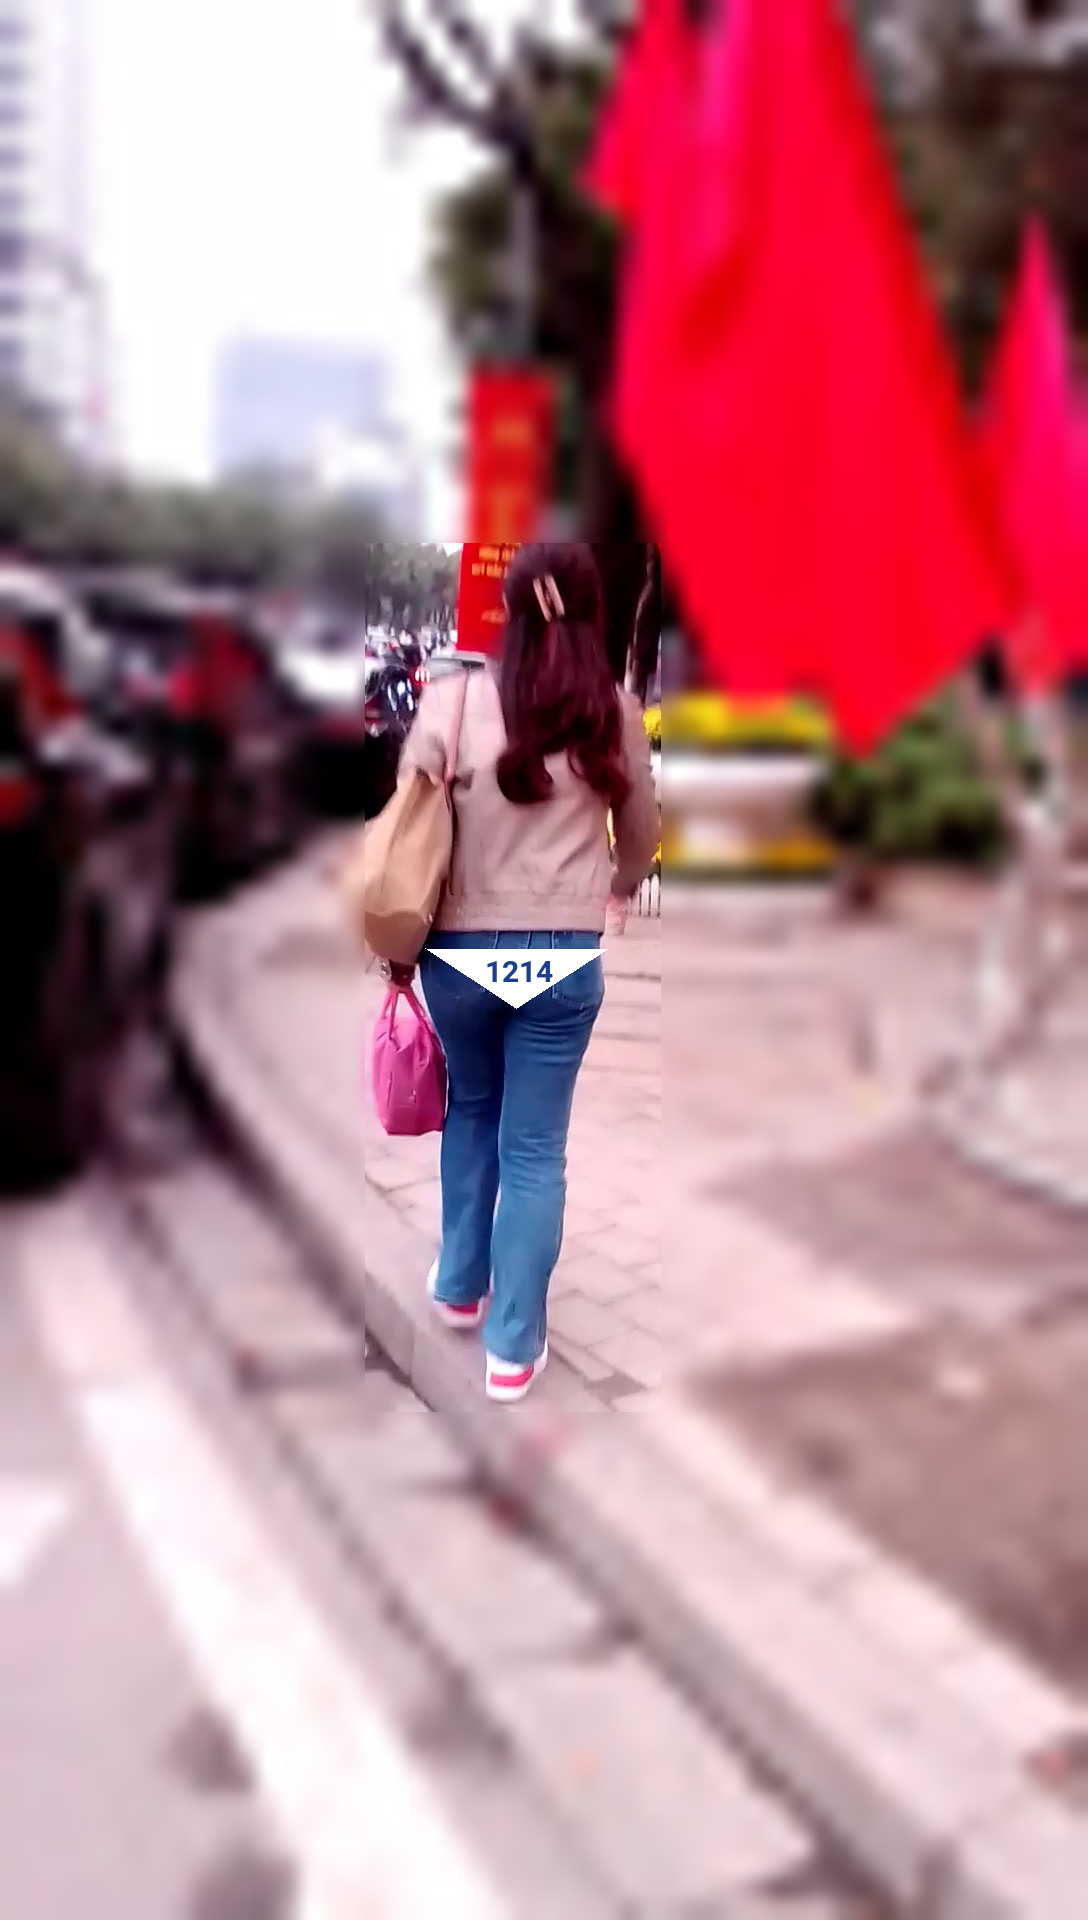

In [7]:
thong_frame, scores, measures = add_thong_score_to_frame(sample_frame)
thong_frame

In [8]:
from torchvision.transforms.functional import to_pil_image

pil_thong_frames = []
thong_scores = []
thong_measures = []

for index, vid_frame in enumerate(video):
    print("processing frame ", index, " of ", frame_counts)
    frame = to_pil_image(vid_frame)
    frame = frame.rotate(-90, expand=True)
    pil_thong, scores, measures= add_thong_score_to_frame(frame)
    thong_scores.append(scores)
    thong_measures.append(measures)
    pil_thong_frames.append(pil_thong)
    

processing frame  0  of  64
Found  1  person in the frame
Distances:  [22.337646484375]
Areas:  [257874.62483160198]
FOCUSES:  [11544.395467623823]
Select keypoint index 0
Found  3  person in the frame
[0.0, 571.8336181640625, 193.26808166503906, 1195.1561279296875]
[372.3245849609375, 533.3035278320312, 671.0001220703125, 1396.6973876953125]
[370.21514892578125, 518.4943237304688, 672.1202392578125, 1394.2218017578125]
[372.3245849609375, 533.3035278320312, 671.0001220703125, 1396.6973876953125]
[61.422096252441406, 566.1066284179688, 318.2737121582031, 886.5347900390625]
[372.3245849609375, 533.3035278320312, 671.0001220703125, 1396.6973876953125]
[432.7727197066315, 8.656539702398444, 408.7405670249833]
8.656539702398444 1
8
processing frame  1  of  64
Found  1  person in the frame
Distances:  [30.26031494140625]
Areas:  [257249.08763182163]
FOCUSES:  [8501.20324689082]
Select keypoint index 0
Found  4  person in the frame
[356.65777587890625, 534.4133911132812, 663.7716064453125, 1

Still Find Best Frame VIA Histogram 

1124.844827586207 1129.5


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


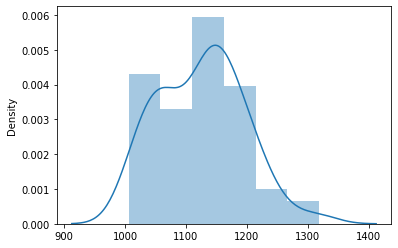

In [9]:
mean, median, minim, maxim = score.best_scores(
    thong_scores,
    1000, 
    1800
)

best_score, frame_index = score.find_nearest(
    thong_scores, 
    median
)

In [10]:
frame_index

3

In [11]:
export.generate_instagram_vid(
    vid_name="lieugiai_vanphuc_with_thong.mp4", 
    vid_width = sample_frame.width, 
    vid_height = sample_frame.height, 
    pil_images = pil_thong_frames, 
    stop_index=frame_index, 
    fps=fps, 
    repeat_rate=2, 
    slow_motion_rate=1
)

Total Frames is  256
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
63 1
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
10 2
11 2
12 2
13 2
14 2
15 2
16 2
17 2
18 2
19 2
20 2
21 2
22 2
23 2
24 2
25 2
26 2
27 2
28 2
29 2
30 2
31 2
32 2
33 2
34 2
35 2
36 2
37 2
38 2
39 2
40 2
41 2
42 2
43 2
44 2
45 2
46 2
47 2
48 2
49 2
50 2
51 2
52 2
53 2
54 2
55 2
56 2
57 2
58 2
59 2
60 2
61 2
62 2
63 2
63 3
62 3
61 3
60 3
59 3
58 3
57 3
56 3